In [1]:
import tensorflow as tf
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots

In [2]:
from util.data_loader import *
dataset = data_loader('data/kitti-compressed-resized.npy', 'data/kitti_resize_metadata.json')

Data loaded! Took 10.03 seconds
Data Shape (7429, 128, 384, 3)
train: 6351   test: 1053


In [4]:
def conv_block(inputs, conv_filter, conv_kernel):
    conv1 = tf.layers.conv2d(inputs, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=tf.nn.relu)
    conv3 = tf.layers.conv2d(conv2, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=tf.nn.relu)
    pooled = tf.layers.max_pooling2d(conv3, (2,2), (2,2))
    return pooled
def dconv_block(inputs, dconv_filter, dconv_kernel, dconv_strides, res_conv = None):
    dconv = tf.layers.conv2d_transpose(inputs,
                                       dconv_filter,
                                       dconv_kernel,
                                       dconv_strides,
                                       padding='same',
                                       activation=tf.nn.relu)
    conv1 = tf.layers.conv2d(dconv, 
                             dconv_filter, 
                             (3,3),
                             padding='same', 
                             activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, 
                             dconv_filter, 
                             (3,3),
                             padding='same', 
                             activation=tf.nn.relu)
    if res_conv == None:
        return conv2
    conv_concat = tf.concat([conv2, res_conv],3)
    return conv_concat

In [12]:
tf.reset_default_graph()
def deep_CNN_model(X,y):
    conv_block1 = conv_block(X, 48, (3,3))
    conv_block2 = conv_block(conv_block1, 48, (3,3))
    conv_block3 = conv_block(conv_block2, 96, (3,3))
    conv_block4 = conv_block(conv_block3, 96, (3,3))
    conv_block5 = conv_block(conv_block4, 96, (3,3))
    dconv_block5 = dconv_block(conv_block5, 96, (4,4), (2,2), conv_block4)
    dconv_block4 = dconv_block(dconv_block5, 96, (4,4), (2,2), conv_block3)
    dconv_block3 = dconv_block(dconv_block4, 96, (4,4), (2,2), conv_block2)
    dconv_block2 = dconv_block(dconv_block3, 48, (4,4), (2,2), conv_block1)
    dconv_block1 = dconv_block(dconv_block2, 3, (4,4), (2,2))
    y_out = dconv_block1
    return y_out

X = tf.placeholder(tf.float32, [None, 128, 384, 6])
y = tf.placeholder(tf.float32, [None, 128, 384, 3])

learning_rate = 1e-3
y_out = deep_CNN_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
## Charbonnier Loss
# epsilon = 0.1
# batch_loss = tf.reduce_sum(tf.sqrt((y_out - y) ** 2 + (epsilon * tf.ones_like(y)) ** 2), [1,2,3])
# mean_loss = tf.reduce_mean(batch_loss)
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

batch : 0  Mean Loss: 8.760e+09
batch : 50  Mean Loss: 4.319e+08
batch : 100  Mean Loss: 2.412e+08
batch : 150  Mean Loss: 1.692e+08
batch : 200  Mean Loss: 1.254e+08
batch : 250  Mean Loss: 9.301e+07
batch : 300  Mean Loss: 9.533e+07
batch : 350  Mean Loss: 9.230e+07
batch : 400  Mean Loss: 8.625e+07
batch : 450  Mean Loss: 9.379e+07
batch : 500  Mean Loss: 8.223e+07
batch : 550  Mean Loss: 7.762e+07
batch : 600  Mean Loss: 6.071e+07
batch : 650  Mean Loss: 7.047e+07
batch : 700  Mean Loss: 6.073e+07
batch : 750  Mean Loss: 7.069e+07
batch : 800  Mean Loss: 6.615e+07
batch : 850  Mean Loss: 6.912e+07
batch : 900  Mean Loss: 5.362e+07
batch : 950  Mean Loss: 5.665e+07
batch : 1000  Mean Loss: 6.271e+07
batch : 1050  Mean Loss: 5.632e+07
batch : 1100  Mean Loss: 4.691e+07
batch : 1150  Mean Loss: 5.479e+07
batch : 1200  Mean Loss: 4.331e+07
batch : 1250  Mean Loss: 3.836e+07
batch : 1300  Mean Loss: 3.102e+07
batch : 1350  Mean Loss: 4.079e+07
batch : 1400  Mean Loss: 3.153e+07
batch : 

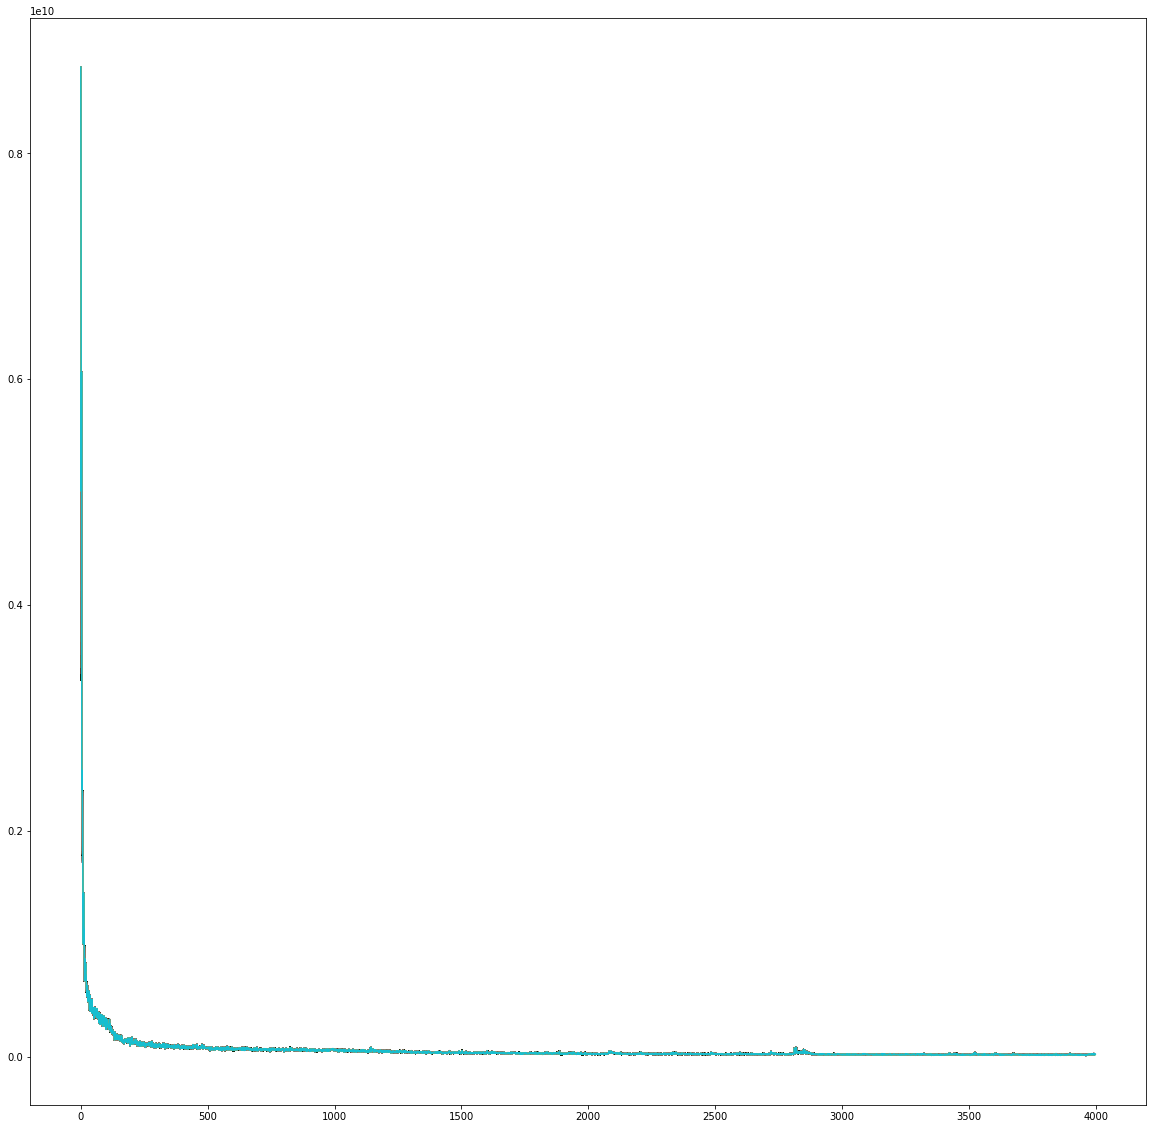

In [14]:
iterations = 4000
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [mean_loss,train_step]
history = []
for e in range(iterations):
    batch_x, batch_y = dataset.get_batch()
    feed_dict = {X: batch_x, y: batch_y}
    loss, _ = sess.run(variables,feed_dict=feed_dict)
    history.append(loss)
    if e % 50 == 0:
        print('batch : {0}  Mean Loss: {1:.3e}'.format(e, loss))
    plt.plot(history)

In [19]:
batch_x, batch_y = dataset.get_batch()
feed_dict = {X: batch_x, y: batch_y}
pred, loss = sess.run([y_out, mean_loss],feed_dict=feed_dict)

In [20]:
loss

21101762.0

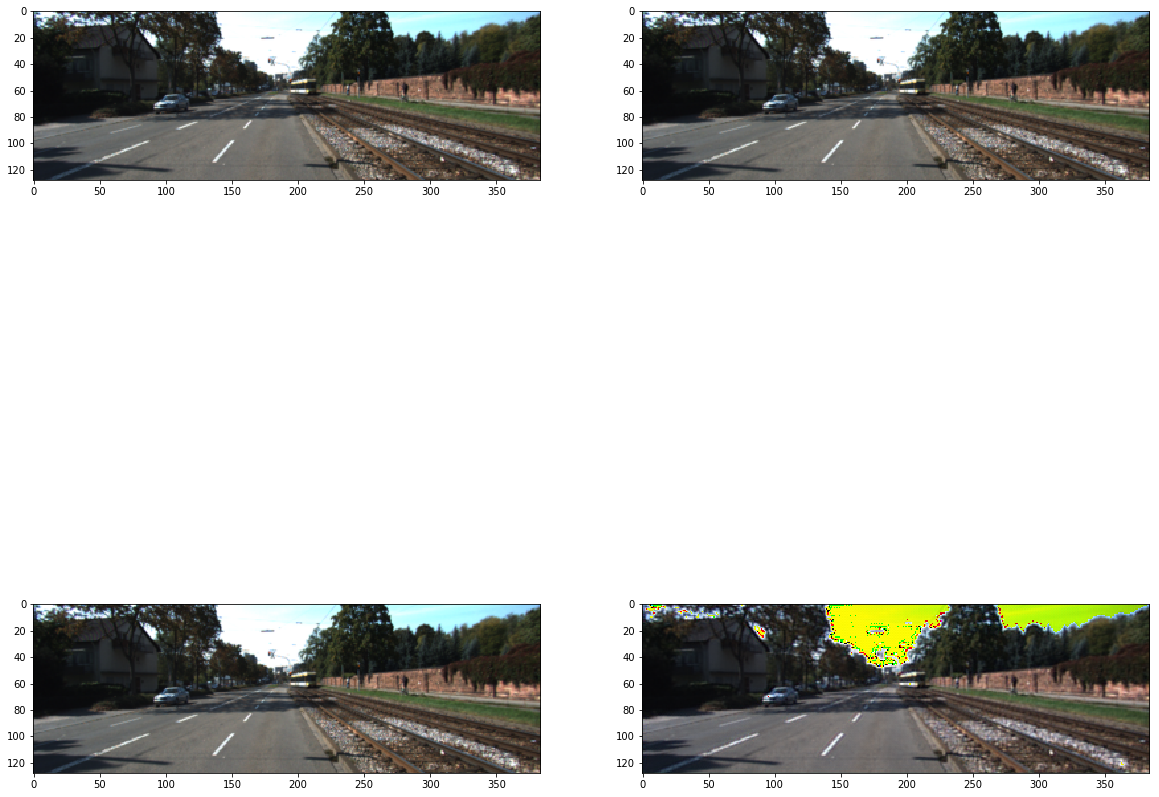

In [21]:
test_ind = 1
plt.subplot(221)
plt.imshow((batch_x[test_ind,:,:,:3]).astype('uint8'))
plt.subplot(222)
plt.imshow((batch_x[test_ind,:,:,3:]).astype('uint8'))
plt.subplot(223)
plt.imshow((batch_y[test_ind,:,:,:]).astype('uint8'))
plt.subplot(224)
plt.imshow((pred[test_ind,:,:,:]).astype('uint8'))